<a href="https://colab.research.google.com/github/toby-j/COM3025-CW/blob/main/Eff_net_gradients_with_Demographics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports



In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import cv2
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from keras import Sequential
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
import PIL.Image
from torchvision import models, transforms
from matplotlib import pylab as P
import numpy as np
from PIL import Image
import tensorflow
from keras.applications import EfficientNetB0
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


# Global functions

## Metrics

In [2]:
def plot_loss(history):
  # Plotting the loss graph
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Plotting the accuracy graph
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [3]:
def plot_confusion_matrix(model, X_test, y_test):
  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis=-1)
  
  # Filter out continuous-multioutput targets from y_test
  y_test_classes = np.argmax(y_test, axis=-1)
  
  confusion_matrix = metrics.confusion_matrix(y_test_classes, y_pred_classes)

  labels = list(set(y_test_classes) | set(y_pred_classes))
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

  fig, ax = plt.subplots(figsize=(10, 8))
  cm_display.plot(ax=ax)

  plt.show()

In [4]:
def output_metrics(model, X_test, y_test):
    # Use the trained model to make predictions on the test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=-1)
    y_test = np.argmax(y_test, axis=-1)
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred_classes, average='weighted')

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_classes)

    # Calculate precision
    precision = precision_score(y_test, y_pred_classes, average='weighted')

    # Calculate recall
    recall = recall_score(y_test, y_pred_classes, average='weighted')

    # Print the metrics
    print(f'F1 score: {f1:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'Accuracy: {accuracy:.2f}')

In [5]:
def output_MLP_metrics(model, data, labels):
  predictions = model.predict(data)

  y_pred  = np.argmax(predictions, axis=-1)

  print(f'Accuracy score: {accuracy_score(labels, y_pred)}')
  print(f'F1 score: {f1_score(labels, y_pred, average="weighted")}')
  print(f'Precision score: {precision_score(labels, y_pred, average="weighted")}')
  print(f'Recall score: {recall_score(labels, y_pred, average="weighted")}')

In [6]:
def plot_MLP_confusion_matrix(model, X_test, y_test):
  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis=-1)
  
  confusion_matrix = metrics.confusion_matrix(y_test, y_pred_classes)

  labels = list(set(y_test) | set(y_pred_classes))
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

  fig, ax = plt.subplots(figsize=(10, 8))
  cm_display.plot(ax=ax)

  plt.show()

## Processing

In [7]:
def load_images_from_folder(folder_path):
    image_paths = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            image_paths.append(img_path)
    return image_paths

In [8]:
def read_and_resize_image(image_path, size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    return img

In [9]:
def normaliseGradients(image_3d, percentile=99):
    image_2d = np.sum(np.abs(image_3d), axis=2)

    # Get max pixel value in the image
    vmax = np.percentile(image_2d, percentile)
    # Get minimum pixel value in the image
    vmin = np.min(image_2d)

    # Normalise the values. We clip intensities so values lower than 0 are equal 0.
    return np.clip((image_2d - vmin) / (vmax - vmin), 0, 1)

In [10]:
def convert_to_boolean_mask(image):
    # Convert the image to a NumPy array
    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    # Create a boolean mask where white pixels are True and black pixels are False
    binary_image = np.where(image == 255, False, True)  # Assuming white pixels are represented as 255

    cropped_image = cv2.resize(binary_image.astype(np.uint8), image_size)

    return cropped_image

## Calculations

In [11]:
def calculate_overlap(g, m):
    # Invert the mask, so the pixels outside are True.
    # Replace where the mask is False, with a 0 in the same location in raw_gradients
    segment = np.where(np.array(m), np.array(g), 0)

    # We now have just the gradients in a 2D vector of the pixels outside the bounding box
    sum_mask_segment = np.sum(segment)
    # Find what percentage the outside pixels make up of the full gradient image by summing both 2D vectors
    total_sum = np.sum(g)
    # What percentage are the gradients outside the segment of the full gradient vector
    overlap = (sum_mask_segment / total_sum) * 100

    return overlap

## Utilities

In [12]:
def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

In [13]:
transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    #
    # torchvision have color channel as first dimension
    # with normalization relative to mean/std of ImageNet:
    #    https://pytorch.org/vision/stable/models.html
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images)
    return images.requires_grad_(True)

In [14]:
def visualiseImageToHeatmap(image_3d, percentile=99):
    r"""Returns a 3D tensor as RGB 3D heatmap
    Pixels with higher weightage in sailiency heatmap will most saturated and will correspond to high RGB values in output heatmap_rgb
  """
    image_2d = normaliseGradients(image_3d)
    # Create heatmap using "jet" colormap, which returns an RGBA image
    heatmap = plt.get_cmap('jet')(image_2d) * 255

    # Normalise to 0,255 so it's visible when pasted
    return Image.fromarray(heatmap.astype(np.uint8), mode='RGBA'), image_2d

In [15]:
def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = im.resize((299, 299))
    im = np.asarray(im)
    return im

In [16]:
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

# Global Variables

In [17]:
# This variable is used to globally set the size of the images used for training and viaulisation.
# All images must be the same size for the techniques to work.
image_size = (128, 128)
lesion_segment_path = "/content/HAM10000_segmentations_lesion_tschandl/"

# Kaggle dataset loading
If you're using your local machine, download the dataset into root/contents
Kaggle doesn't have the segmentation images. Download this folder from the Harvard dataverse and place in /contents:

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T
https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

You need a kaggle.json api key.

In [18]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip -d content
#Removing the zip to save space
!rm skin-cancer-mnist-ham10000.zip

Saving kaggle.json to kaggle.json
 99% 5.17G/5.20G [00:16<00:00, 295MB/s]
100% 5.20G/5.20G [00:16<00:00, 345MB/s]


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading segment images from Drive

In [20]:
!unzip -q /content/drive/MyDrive/HAM10000_segmentations_lesion_tschandl.zip -d content

## Dataset cleaning

In [21]:
df = pd.read_csv('content/HAM10000_metadata.csv')

In [22]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [23]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Bening keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
ds_dir = 'content/'

In [24]:
from glob import glob
## Let's map the image_id with it's image path from part 1 and part 2 folders
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(ds_dir, '*', '*.jpg'))}

In [25]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [26]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [27]:
# Fill in the null values with the average age
df['age'].fillna((df['age'].mean()), inplace=True)

In [28]:
# Check our dataset is cleaned for null values
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

# Smoothgrad


In [29]:
class_idx_str = 'class_idx_str'

In [30]:
INPUT_OUTPUT_GRADIENTS = 'INPUT_OUTPUT_GRADIENTS'
CONVOLUTION_LAYER_VALUES = 'CONVOLUTION_LAYER_VALUES'
CONVOLUTION_OUTPUT_GRADIENTS = 'CONVOLUTION_OUTPUT_GRADIENTS'

In [31]:
expected_keys = [INPUT_OUTPUT_GRADIENTS]

In [32]:
conv_layer_outputs = {}

In [33]:
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = new_model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = new_model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {CONVOLUTION_LAYER_VALUES: conv_layer,
                    CONVOLUTION_OUTPUT_GRADIENTS: gradients}

In [34]:
def format_and_check_call_model_output(self, output, input_shape, expected_keys):
  """Converts keys in the output into an np.ndarray, and confirms its shape.

  Args:
    output: The output dictionary of data to be formatted.
    input_shape: The shape of the input that yielded the output
    expected_keys: List of keys inside output to format/check for shape agreement.

  Raises:
      ValueError: If output shapes do not match expected shape."""
  # If key is in check_full_shape, the shape should be equal to the input shape (e.g. 
  # INPUT_OUTPUT_GRADIENTS, which gives gradients for each value of the input). Otherwise,
  # only checks the outermost dimension of output to match input_shape (i.e. the batch size
  # should be the same).
  check_full_shape = [INPUT_OUTPUT_GRADIENTS]
  for expected_key in expected_keys:
    output[expected_key] = np.asarray(output[expected_key])
    expected_shape = input_shape
    actual_shape = output[expected_key].shape
    if expected_key not in check_full_shape:
      expected_shape = expected_shape[0]
      actual_shape = actual_shape[0]
    if expected_shape != actual_shape:
      raise ValueError(SHAPE_ERROR_MESSAGE[expected_key].format(
                      expected_shape, actual_shape))

In [35]:
# Output of the last convolution layer for the given input, including the batch
# dimension.
CONVOLUTION_LAYER_VALUES = 'CONVOLUTION_LAYER_VALUES'
# Gradients of the output being explained (the logit/softmax value) with respect
# to the last convolution layer, including the batch dimension.
CONVOLUTION_OUTPUT_GRADIENTS = 'CONVOLUTION_OUTPUT_GRADIENTS'
# Gradients of the output being explained (the logit/softmax value) with respect
# to the input. Shape should be the same shape as x_value_batch.
INPUT_OUTPUT_GRADIENTS = 'INPUT_OUTPUT_GRADIENTS'
# Value of the output being explained (the logit/softmax value).
OUTPUT_LAYER_VALUES = 'OUTPUT_LAYER_VALUES'

SHAPE_ERROR_MESSAGE = {
    CONVOLUTION_LAYER_VALUES: (
        'Expected outermost dimension of CONVOLUTION_LAYER_VALUES to be the '
        'same as x_value_batch - expected {}, actual {}'
    ),
    CONVOLUTION_OUTPUT_GRADIENTS: (
        'Expected outermost dimension of CONVOLUTION_OUTPUT_GRADIENTS to be the '
        'same as x_value_batch - expected {}, actual {}'
    ),
    INPUT_OUTPUT_GRADIENTS: (
        'Expected key INPUT_OUTPUT_GRADIENTS to be the same shape as input '
        'x_value_batch - expected {}, actual {}'
    ),
    OUTPUT_LAYER_VALUES: (
        'Expected outermost dimension of OUTPUT_LAYER_VALUES to be the same as'
        ' x_value_batch - expected {}, actual {}'
    ),
}


class CoreGradients(object):

  def GetMask(self, x_value, call_model_function, call_model_args=None):
    """Returns an unsmoothed mask.

    Args:
      x_value: Input ndarray.
      call_model_function: A function that interfaces with a model to return
        specific output in a dictionary when given an input and other arguments.
        Expected function signature:
        - call_model_function(x_value_batch,
                              call_model_args=None,
                              expected_keys=None):
          x_value_batch - Input for the model, given as a batch (i.e. dimension
            0 is the batch dimension, dimensions 1 through n represent a single
            input).
          call_model_args - Other arguments used to call and run the model.
          expected_keys - List of keys that are expected in the output. Possible
            keys in this list are CONVOLUTION_LAYER_VALUES, 
            CONVOLUTION_OUTPUT_GRADIENTS, INPUT_OUTPUT_GRADIENTS, and
            OUTPUT_LAYER_VALUES, and are explained in detail where declared.
      call_model_args: The arguments that will be passed to the call model
        function, for every call of the model.

    """
    raise NotImplementedError('A derived class should implemented GetMask()')

  def GetSmoothedMask(self,
                      x_value,
                      call_model_function,
                      call_model_args=None,
                      stdev_spread=.15,
                      nsamples=25,
                      magnitude=True,
                      **kwargs):
    """Returns a mask that is smoothed with the SmoothGrad method.

    Args:
      x_value: Input ndarray.
      call_model_function: A function that interfaces with a model to return
        specific output in a dictionary when given an input and other arguments.
        Expected function signature:
        - call_model_function(x_value_batch,
                              call_model_args=None,
                              expected_keys=None):
          x_value_batch - Input for the model, given as a batch (i.e. dimension
            0 is the batch dimension, dimensions 1 through n represent a single
            input).
          call_model_args - Other arguments used to call and run the model.
          expected_keys - List of keys that are expected in the output. Possible
            keys in this list are CONVOLUTION_LAYER_VALUES,
            CONVOLUTION_OUTPUT_GRADIENTS, INPUT_OUTPUT_GRADIENTS, and
            OUTPUT_LAYER_VALUES, and are explained in detail where declared.
      call_model_args: The arguments that will be passed to the call model
        function, for every call of the model.
      stdev_spread: Amount of noise to add to the input, as fraction of the
                    total spread (x_max - x_min). Defaults to 15%.
      nsamples: Number of samples to average across to get the smooth gradient.
      magnitude: If true, computes the sum of squares of gradients instead of
                 just the sum. Defaults to true.
    """
    stdev = stdev_spread * (np.max(x_value) - np.min(x_value))
    # Starting baseline image
    total_gradients = np.zeros_like(x_value, dtype=np.float32)
    for _ in range(nsamples):
      noise = np.random.normal(0, stdev, x_value.shape)
      # Calculate and add our smoothgrad noise
      x_plus_noise = x_value + noise
      # Get vanilla gradients. The input is the interpolated image + the Smoothgrad noise we generated
      grad = self.GetMask(x_plus_noise, call_model_function, call_model_args,
                          **kwargs)
      if magnitude:
        total_gradients += (grad * grad)
      else:
        total_gradients += grad

    return total_gradients / nsamples

  def format_and_check_call_model_output(self, output, input_shape, expected_keys):
    """Converts keys in the output into an np.ndarray, and confirms its shape.

    Args:
      output: The output dictionary of data to be formatted.
      input_shape: The shape of the input that yielded the output
      expected_keys: List of keys inside output to format/check for shape agreement.

    Raises:
        ValueError: If output shapes do not match expected shape."""
    # If key is in check_full_shape, the shape should be equal to the input shape (e.g. 
    # INPUT_OUTPUT_GRADIENTS, which gives gradients for each value of the input). Otherwise,
    # only checks the outermost dimension of output to match input_shape (i.e. the batch size
    # should be the same).
    check_full_shape = [INPUT_OUTPUT_GRADIENTS]
    for expected_key in expected_keys:
      output[expected_key] = np.asarray(output[expected_key])
      expected_shape = input_shape
      actual_shape = output[expected_key].shape
      if expected_key not in check_full_shape:
        expected_shape = expected_shape[0]
        actual_shape = actual_shape[0]
      if expected_shape != actual_shape:
        raise ValueError(SHAPE_ERROR_MESSAGE[expected_key].format(
                       expected_shape, actual_shape))


In [36]:
# Inherits our smoothgrad technique in CoreGradients
class Gradients(CoreGradients):

  expected_keys = [INPUT_OUTPUT_GRADIENTS]

  def GetMask(self, x_value, call_model_function, call_model_args=None):
    """Returns a vanilla gradients mask.

    Args:
      x_value: Input ndarray.
      call_model_function: A function that interfaces with a model to return
        specific data in a dictionary when given an input and other arguments.
        Expected function signature:
        - call_model_function(x_value_batch,
                              call_model_args=None,
                              expected_keys=None):
          x_value_batch - Input for the model, given as a batch (i.e. dimension
            0 is the batch dimension, dimensions 1 through n represent a single
            input).
          call_model_args - Other arguments used to call and run the model.
          expected_keys - List of keys that are expected in the output. For this
            method (Gradients), the expected keys are
            INPUT_OUTPUT_GRADIENTS - Gradients of the output layer
              (logit/softmax) with respect to the input. Shape should be the
              same shape as x_value_batch.
      call_model_args: The arguments that will be passed to the call model
        function, for every call of the model.
    """
    x_value_batched = np.expand_dims(x_value, axis=0)
    call_model_output = call_model_function(
        x_value_batched,
        call_model_args=call_model_args,
        expected_keys=self.expected_keys)

    # Check gradient calculation is correct
    self.format_and_check_call_model_output(call_model_output,
                                            x_value_batched.shape,
                                            self.expected_keys)

    return call_model_output[INPUT_OUTPUT_GRADIENTS][0]


# Training

In [37]:
# Apply the function to each image path in the 'path' column of the dataframe
df['image'] = df['path'].apply(lambda x: read_and_resize_image(x, image_size))

In [38]:
df['image'].map(lambda x: x.shape).value_counts()

(128, 128, 3)    10015
Name: image, dtype: int64

In [39]:
# Split the data into train and test sets
# We use stratify which splits the dataset with the same class inbalance as the dataset.
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cell_type_idx'], random_state=42)

In [40]:
# Extract the image data and target labels for train and test sets
X_train = np.stack(train_df['image'].values)
y_train = train_df['cell_type_idx'].values
X_test = np.stack(test_df['image'].values)
y_test = test_df['cell_type_idx'].values

In [41]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Create a data generator for data augmentation
train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

# Convert the labels to one-hot encoding for use with categorical_crossentropy
num_classes = df['cell_type_idx'].nunique()
y_train_norm = to_categorical(y_train, num_classes=num_classes)
y_test_norm = to_categorical(y_test, num_classes=num_classes)

# Normalizing the input data to match the format the model was trained on
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Add a custom head for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.2)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # Added L2 regularization
predictions = Dense(num_classes, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers, keeping Batch Normalization layers in inference mode
for layer in base_model.layers:
    if not isinstance(layer, tensorflow.keras.layers.BatchNormalization):
        layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-5:]:
    layer.trainable = True  

# Learning Rate Schedule
lr_schedule = tensorflow.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=0.0010)

# Early Stopping
early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

16705208/16705208 [==============================] - 0s 0us/step


In [42]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
#Train the model
history = model.fit(train_datagen.flow(X_train_norm, y_train_norm, batch_size=64), 
          validation_data=(X_test_norm, y_test_norm), 
          class_weight=class_weights, 
          steps_per_epoch=len(X_train_norm) // 64,
          epochs=50,
          callbacks=[lr_schedule, early_stopping])

Epoch 1/50
125/125 [==============================] - 59s 223ms/step - loss: 5.2990 - accuracy: 0.4538 - val_loss: 4.6170 - val_accuracy: 0.0115 - lr: 0.0010
Epoch 2/50
125/125 [==============================] - 28s 224ms/step - loss: 2.3042 - accuracy: 0.5271 - val_loss: 2.5380 - val_accuracy: 0.4833 - lr: 0.0010
Epoch 3/50
125/125 [==============================] - 28s 223ms/step - loss: 1.6062 - accuracy: 0.5516 - val_loss: 2.7485 - val_accuracy: 0.0744 - lr: 0.0010
Epoch 4/50
125/125 [==============================] - 28s 225ms/step - loss: 1.4017 - accuracy: 0.5610 - val_loss: 2.0391 - val_accuracy: 0.3130 - lr: 0.0010
Epoch 5/50
125/125 [==============================] - 28s 222ms/step - loss: 1.2791 - accuracy: 0.5815 - val_loss: 2.2327 - val_accuracy: 0.2831 - lr: 0.0010
Epoch 6/50
125/125 [==============================] - 28s 223ms/step - loss: 1.2660 - accuracy: 0.5998 - val_loss: 2.8351 - val_accuracy: 0.2272 - lr: 0.0010
Epoch 7/50
125/125 [==============================] 

## Metric ouputs

63/63 [==============================] - 2s 9ms/step
F1 score: 0.74
Precision: 0.80
Recall: 0.72
Accuracy: 0.72
63/63 [==============================] - 1s 8ms/step


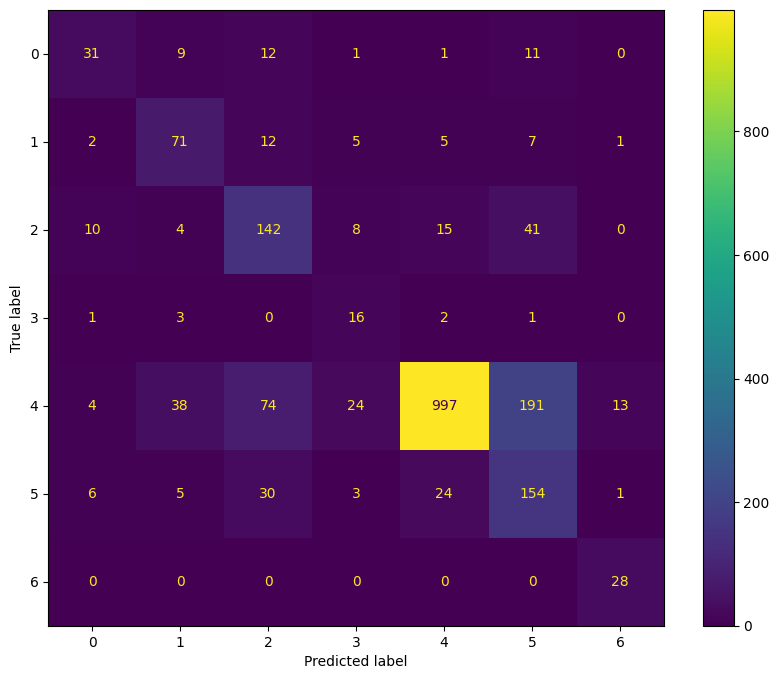

In [44]:
output_metrics(model, X_test_norm, y_test_norm)
plot_confusion_matrix(model, X_test_norm, y_test_norm)

# Visualisation Application

In [46]:
heatmap_images = []
raw_gradients = []

In [47]:
# Find the index of the last convolutional layer
last_conv_index = None
for i, layer in enumerate(model.layers[::-1]):
    if 'conv' in layer.name:
        last_conv_index = len(model.layers) - 1 - i
        break

if last_conv_index is not None:
    # Select the last convolutional layer
    last_conv_layer = model.get_layer(index=last_conv_index)

    # Create a new model with the last convolutional layer as output
    new_model = tf.keras.models.Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    # Print information about the selected layer
    print("Selected layer name:", last_conv_layer.name)
    print("Selected layer output shape:", last_conv_layer.output_shape)
else:
    print("No convolutional layer found in the model.")

Selected layer name: top_conv
Selected layer output shape: (None, 4, 4, 1280)


In [48]:
smoothgrad = Gradients()

In [49]:
images = df['path']

In [50]:
predictions = model.predict(X_test)

63/63 [==============================] - 2s 7ms/step


In [51]:
baseline = np.zeros(image_size)
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

In [67]:
# Initialize an empty DataFrame to store the collected samples
collected_samples = pd.DataFrame(columns=df.columns)

# Iterate over each unique class value
for class_value in range(6):
    # Filter the DataFrame to select samples with the current class value
    class_samples = df[df['cell_type_idx'] == class_value].sample(n=50, random_state=42)
    
    # Append the selected samples to the collected_samples DataFrame
    collected_samples = pd.concat([collected_samples, class_samples], ignore_index=True)

In [68]:
from tqdm import tqdm

images = collected_samples['path']

progress_bar = tqdm(total=len(images))

for img in images:
  img_arr = read_and_resize_image(image_path=img, size=image_size)
  im_tensor = PreprocessImages([img_arr])
  im = img_arr.astype(np.float32)
  vanilla_integrated_gradients_mask_3d = smoothgrad.GetSmoothedMask(
    im, call_model_function, call_model_args)
  raw_gradients.append(vanilla_integrated_gradients_mask_3d)
  
  # Update the progress bar
  progress_bar.update(1)

# Close the progress bar
progress_bar.close()

100%|██████████| 300/300 [42:17<00:00,  8.46s/it]


In [69]:
segment_image_list = load_images_from_folder("/content/content/HAM10000_segmentations_lesion_tschandl")

In [70]:
boolean_masks = []
for img in segment_image_list:
    boolean_masks.append(convert_to_boolean_mask(img))

In [71]:
overlap = []
for i in range(len(images)):
    per = [calculate_overlap(raw_gradients[i][:, :, 0], boolean_masks[i]), np.argmax(predictions, axis=1)[i]]
    if str(per[0]) != "nan":
      overlap.append(per)


<ipython-input-11-3225b9d9aa76>:11: RuntimeWarning: invalid value encountered in float_scalars
  overlap = (sum_mask_segment / total_sum) * 100


<Figure size 1000x600 with 0 Axes>

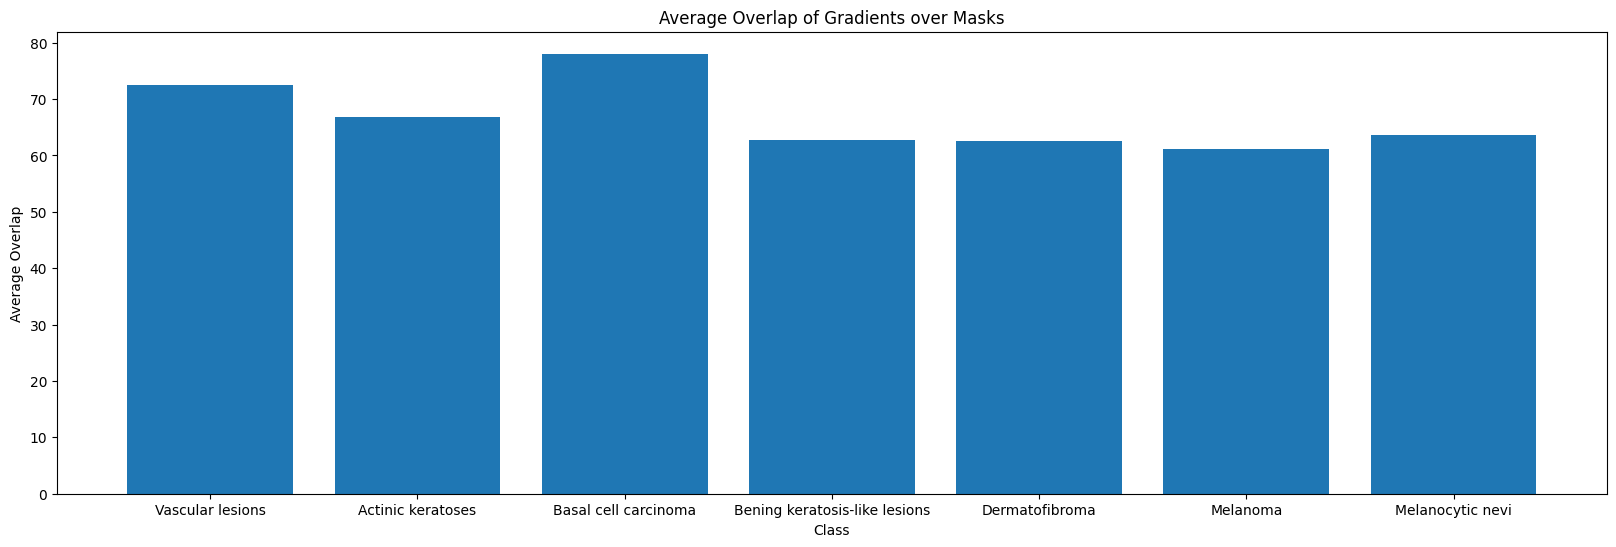

In [72]:
from collections import defaultdict

# Calculate average overlap for each class
class_overlaps = defaultdict(list)
for item in overlap:
    overlap_value = item[0]
    class_label = item[1]
    class_overlaps[class_label].append(overlap_value)

class_labels = []
average_overlaps = []

for class_label, overlaps in class_overlaps.items():
    class_labels.append(class_label)
    average_overlap = sum(overlaps) / len(overlaps)
    average_overlaps.append(average_overlap)

# Create a bar chart or scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference

mapped_labels = [list(lesion_type_dict.values())[label] for label in class_labels]

plt.figure(figsize=(20, 6))
# Bar chart
plt.bar(range(len(average_overlaps)), average_overlaps)
plt.xticks(range(len(average_overlaps)), mapped_labels)
plt.xlabel('Class')
plt.ylabel('Average Overlap')
plt.title('Average Overlap of Gradients over Masks')

plt.show()

In [73]:
for label, overlap in zip(mapped_labels, average_overlaps):
    print(f"Label: {label}, Average Overlap: {overlap}")

Label: Vascular lesions, Average Overlap: 72.41308518818447
Label: Actinic keratoses, Average Overlap: 66.88361366844104
Label: Basal cell carcinoma, Average Overlap: 78.04340774362737
Label: Bening keratosis-like lesions, Average Overlap: 62.74054874307834
Label: Dermatofibroma, Average Overlap: 62.52342531314263
Label: Melanoma, Average Overlap: 61.19891069829464
Label: Melanocytic nevi, Average Overlap: 63.58760807663202


# MLP

In [74]:
EffNet = model
from keras.layers import Input, concatenate

def perceptron():
  mlp = Sequential()
  mlp.add(Input(shape=(3,)))
  mlp.add(Flatten())
  mlp.add(Dense(128, activation='relu'))
  mlp.add(Dropout(0.5))
  mlp.add(Dense(64, activation='relu'))
  mlp.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))
  return mlp

In [75]:
perceptron = perceptron()
perceptron.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [76]:
sex_dict = {
    'male': 0.0,
    'female': 1.0,
    'unknown': 1.5
}

loc_dict = {
    'back': 1.0,
    'lower extremity': 2.0,
    'trunk': 3.0,
    'upper extremity': 4.0,
    'abdomen': 5.0,
    'face': 6.0,
    'chest': 7.0,
    'foot': 8.0,
    'unknown': 9.0,
    'neck': 10.0,
    'scalp': 11.0,
    'hand': 12.0,
    'ear': 13.0,
    'genital': 14.0,
    'acral': 15.0
}

train_df = train_df.replace({"sex": sex_dict})
train_df = train_df.replace({"localization": loc_dict})
test_df = test_df.replace({"sex": sex_dict})
test_df = test_df.replace({"localization": loc_dict})

#Extract and recombine the demographic data for training set and test set
X_train_demo = np.stack((np.asarray(train_df['age'].values), np.asarray(train_df['sex'].values), np.asarray(train_df['localization'].values)))
y_train = train_df['cell_type_idx'].values
X_test_demo = np.stack((np.asarray(test_df['age'].values), np.asarray(test_df['sex'].values), np.asarray(test_df['localization'].values)))
y_test = test_df['cell_type_idx'].values

X_train_demo=X_train_demo.T.astype(int)
X_test_demo=X_test_demo.T.astype(int)

In [77]:
perceptron_history = perceptron.fit(X_train_demo, y_train, batch_size=256, epochs=50, validation_split=0.3)

Epoch 1/50
22/22 [==============================] - 2s 13ms/step - loss: 3.6095 - accuracy: 0.4415 - val_loss: 1.4582 - val_accuracy: 0.6705
Epoch 2/50
22/22 [==============================] - 0s 5ms/step - loss: 2.2804 - accuracy: 0.4777 - val_loss: 1.4790 - val_accuracy: 0.6697
Epoch 3/50
22/22 [==============================] - 0s 5ms/step - loss: 1.8456 - accuracy: 0.5374 - val_loss: 1.4291 - val_accuracy: 0.6710
Epoch 4/50
22/22 [==============================] - 0s 5ms/step - loss: 1.6654 - accuracy: 0.5704 - val_loss: 1.3935 - val_accuracy: 0.6710
Epoch 5/50
22/22 [==============================] - 0s 5ms/step - loss: 1.5246 - accuracy: 0.5995 - val_loss: 1.3466 - val_accuracy: 0.6710
Epoch 6/50
22/22 [==============================] - 0s 5ms/step - loss: 1.4510 - accuracy: 0.6209 - val_loss: 1.3283 - val_accuracy: 0.6710
Epoch 7/50
22/22 [==============================] - 0s 5ms/step - loss: 1.4247 - accuracy: 0.6336 - val_loss: 1.3084 - val_accuracy: 0.6710
Epoch 8/50
22/22 [=

63/63 [==============================] - 0s 1ms/step
Accuracy score: 0.6744882675986021
F1 score: 0.554105701198621
Precision score: 0.49684095863336936
Recall score: 0.6744882675986021
63/63 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


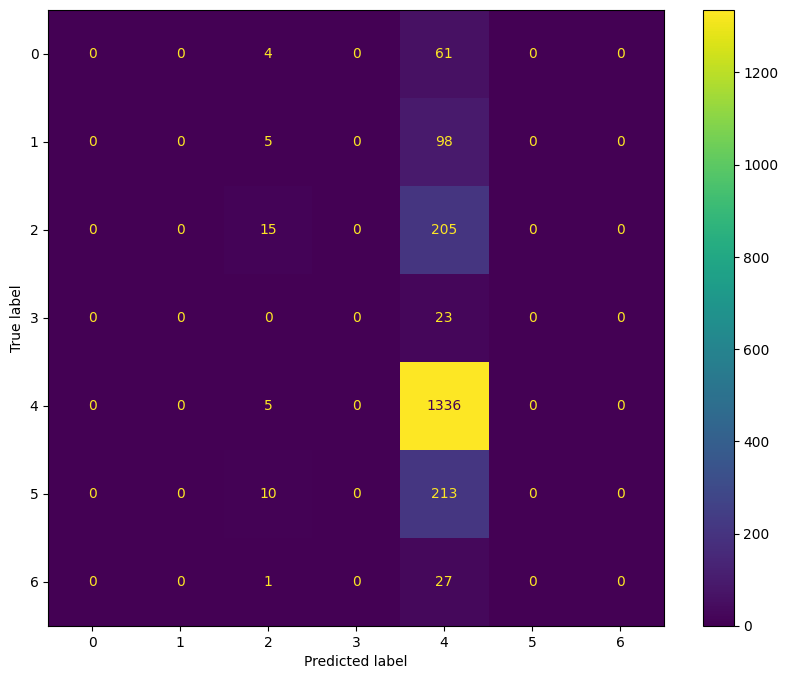

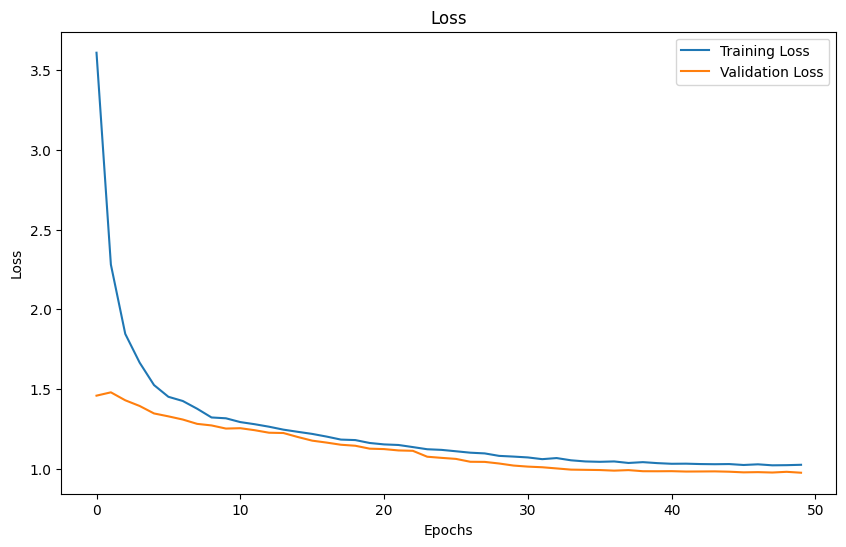

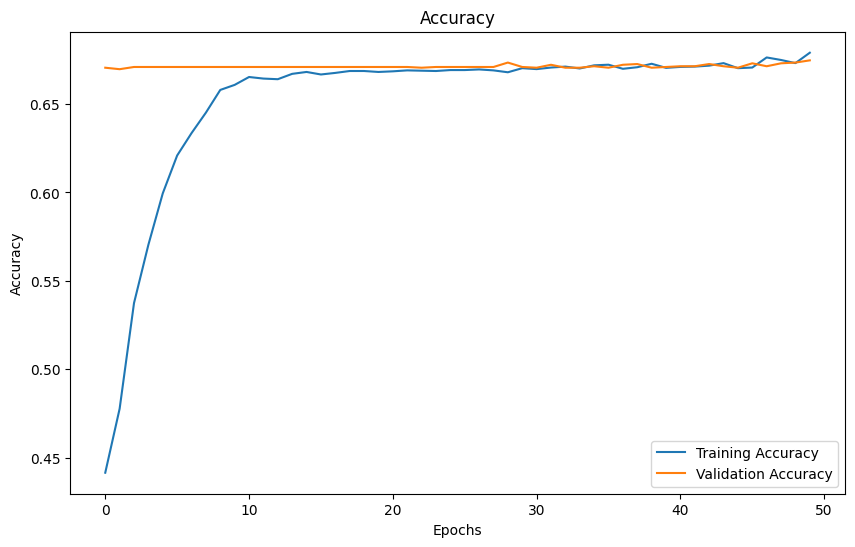

In [78]:
# Use the trained model to make predictions on the test data
output_MLP_metrics(perceptron, X_test_demo, y_test)
plot_MLP_confusion_matrix(perceptron, X_test_demo, y_test)
plot_loss(perceptron_history)

In [79]:
concatenated_inputs = concatenate(inputs=[perceptron.output, EffNet.output])
x = Dense(128, activation="relu")(concatenated_inputs)
x = Dense(64, activation="relu")(x)
x = Dense(len(df['cell_type_idx'].unique()), activation='softmax')(x)
model = Model(inputs=[perceptron.input, EffNet.input], outputs=x)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [80]:
model_history = model.fit([X_train_demo, X_train], y_train, batch_size=256, epochs=50, validation_split=0.3)

Epoch 1/50
22/22 [==============================] - 30s 218ms/step - loss: 1.6729 - accuracy: 0.6118 - val_loss: 1.4217 - val_accuracy: 0.6710
Epoch 2/50
22/22 [==============================] - 3s 135ms/step - loss: 1.0286 - accuracy: 0.7063 - val_loss: 1.1656 - val_accuracy: 0.6477
Epoch 3/50
22/22 [==============================] - 3s 135ms/step - loss: 0.7518 - accuracy: 0.7632 - val_loss: 0.9431 - val_accuracy: 0.7221
Epoch 4/50
22/22 [==============================] - 3s 136ms/step - loss: 0.6538 - accuracy: 0.8049 - val_loss: 0.8920 - val_accuracy: 0.7259
Epoch 5/50
22/22 [==============================] - 3s 135ms/step - loss: 0.5876 - accuracy: 0.8277 - val_loss: 0.9409 - val_accuracy: 0.7463
Epoch 6/50
22/22 [==============================] - 3s 135ms/step - loss: 0.5128 - accuracy: 0.8536 - val_loss: 0.8709 - val_accuracy: 0.7562
Epoch 7/50
22/22 [==============================] - 3s 135ms/step - loss: 0.4477 - accuracy: 0.8755 - val_loss: 0.7714 - val_accuracy: 0.7808
Epoch

63/63 [==============================] - 2s 8ms/step
Accuracy score: 0.8097853220169745
F1 score: 0.8054552433560884
Precision score: 0.8048025005527311
Recall score: 0.8097853220169745
63/63 [==============================] - 1s 8ms/step


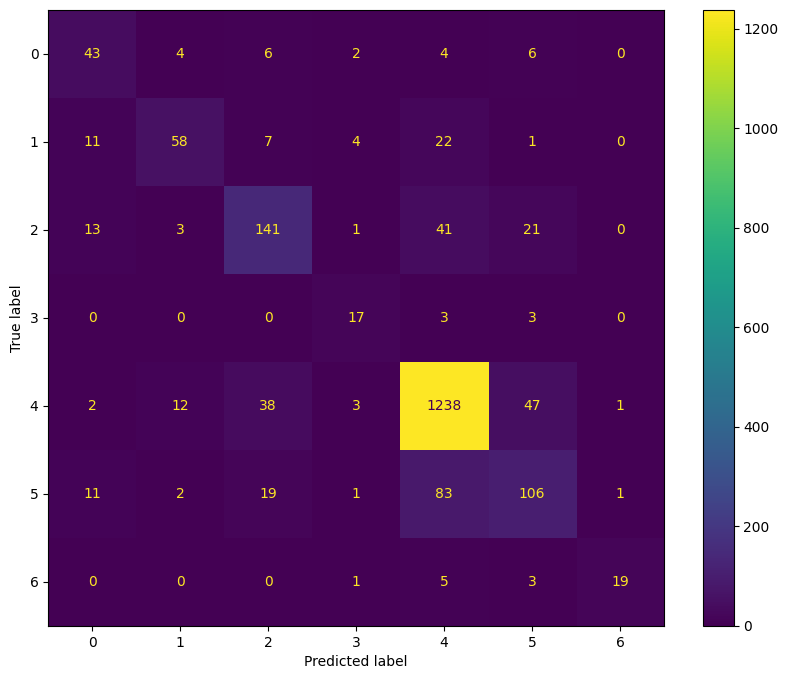

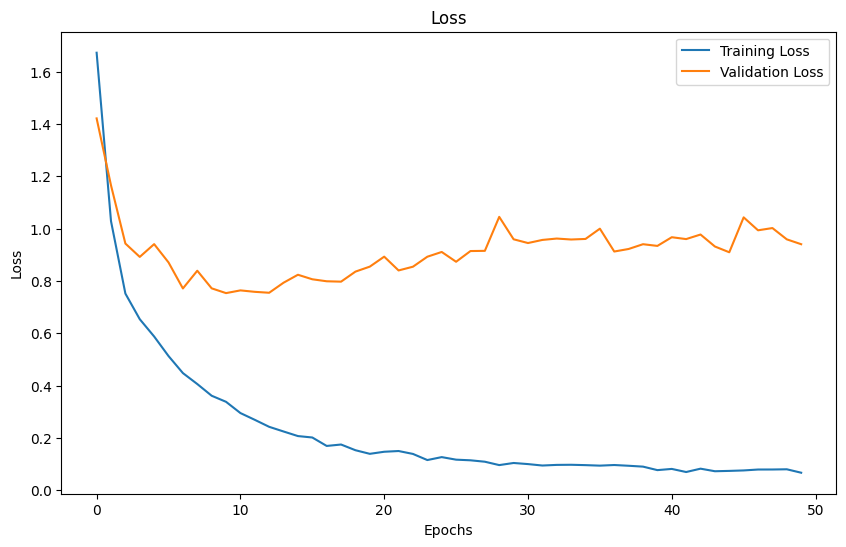

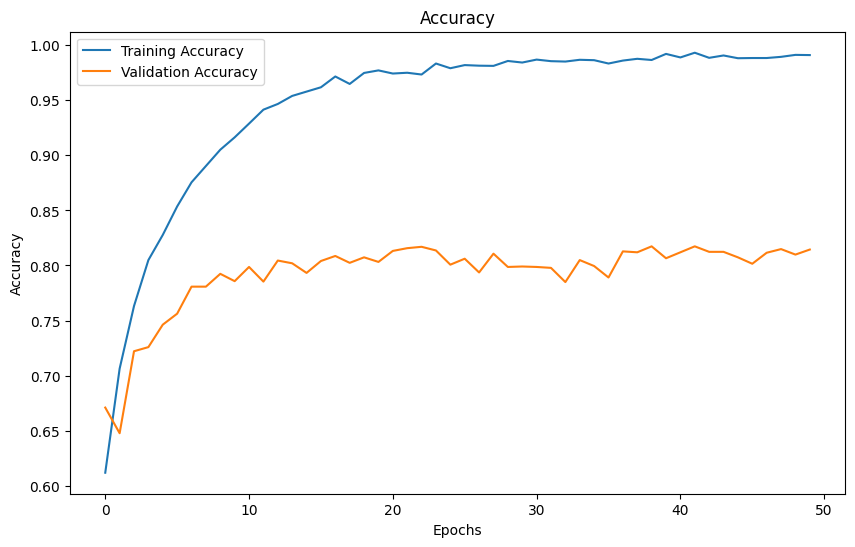

In [81]:
output_MLP_metrics(model, [X_test_demo, X_test], y_test)
plot_MLP_confusion_matrix(model, [X_test_demo, X_test], y_test)
plot_loss(model_history)